# Covid-19 CT-Scan Classifier

## Data Acquisition

### Extracting the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-07-17 08:39:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 2404:6800:4008:c06::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   236MB/s    in 0.4s    

2020-07-17 08:39:27 (236 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# !git clone https://github.com/UCSD-AI4H/COVID-CT.git

In [ ]:
# !unzip '/content/COVID-CT/Images-processed/CT_NonCOVID.zip'

In [ ]:
# !unzip '/content/COVID-CT/Images-processed/CT_COVID.zip'

In [ ]:
# !rm -rf '/content/__MACOSX'

### Splitting Dataset

In [ ]:
import os
# from shutil import copy

In [ ]:
# file_list=[]

# basedir='/content/CT_NonCOVID'
# f = open("/content/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt")
# for i in f.readlines():
#   fname=i.rstrip()
#   copy(os.path.join(basedir,fname),'/content/validation/ncovid')  

### Drive Copy

In [ ]:
!rm -rf test
!cp '/content/drive/My Drive/Colab Data/Covid/test' -r -d test

In [ ]:
!rm -rf train
!cp '/content/drive/My Drive/Colab Data/Covid/train' -r -d train

In [ ]:
!rm -rf validation
!cp '/content/drive/My Drive/Colab Data/Covid/validation' -r -d validation

## Preprocessing

In [ ]:
print('total training covid images:', len(os.listdir('/content/train/covid')))
print('total training non-covid images:', len(os.listdir('/content/train/ncovid')))
print('total validation covid images:', len(os.listdir('/content/validation/covid')))
print('total validation non-covid images:', len(os.listdir('/content/validation/ncovid')))
print('total test covid images:', len(os.listdir('/content/test/covid')))
print('total test non-covid images:', len(os.listdir('/content/test/ncovid')))

total training covid images: 191
total training non-covid images: 234
total validation covid images: 60
total validation non-covid images: 58
total test covid images: 98
total test non-covid images: 105


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/train',class_mode='binary',target_size=(300, 300))
validation_generator = validation_datagen.flow_from_directory('/content/validation',class_mode='binary',target_size=(300, 300))
test_generator = test_datagen.flow_from_directory('/content/test',class_mode='binary',target_size=(300, 300))

Found 425 images belonging to 2 classes.
Found 118 images belonging to 2 classes.
Found 203 images belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (300, 300, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 17, 17, 768)


In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)                  
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x)

In [ ]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(300,300,3)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1024,activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(256,activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(1,activation='sigmoid')
# ])

In [ ]:
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_200[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [ ]:
history = model.fit(train_generator,epochs=50,verbose=2,validation_data=validation_generator)

Epoch 1/50
14/14 - 15s - loss: 13.9325 - acc: 0.5671 - val_loss: 1.0900 - val_acc: 0.5508
Epoch 2/50
14/14 - 12s - loss: 2.1033 - acc: 0.5812 - val_loss: 2.5312 - val_acc: 0.4915
Epoch 3/50
14/14 - 12s - loss: 1.2122 - acc: 0.6188 - val_loss: 1.9606 - val_acc: 0.5169
Epoch 4/50
14/14 - 12s - loss: 0.7542 - acc: 0.6353 - val_loss: 0.8087 - val_acc: 0.5254
Epoch 5/50
14/14 - 12s - loss: 0.6957 - acc: 0.6894 - val_loss: 0.8259 - val_acc: 0.5932
Epoch 6/50
14/14 - 12s - loss: 0.5968 - acc: 0.6753 - val_loss: 0.9772 - val_acc: 0.5508
Epoch 7/50
14/14 - 12s - loss: 0.6436 - acc: 0.6776 - val_loss: 0.9140 - val_acc: 0.5508
Epoch 8/50
14/14 - 12s - loss: 0.5922 - acc: 0.7106 - val_loss: 0.7744 - val_acc: 0.5424
Epoch 9/50
14/14 - 12s - loss: 0.5410 - acc: 0.7271 - val_loss: 0.7158 - val_acc: 0.6271
Epoch 10/50
14/14 - 12s - loss: 0.6285 - acc: 0.7129 - val_loss: 0.6861 - val_acc: 0.6695
Epoch 11/50
14/14 - 12s - loss: 0.4718 - acc: 0.7694 - val_loss: 1.4653 - val_acc: 0.5085
Epoch 12/50
14/14 

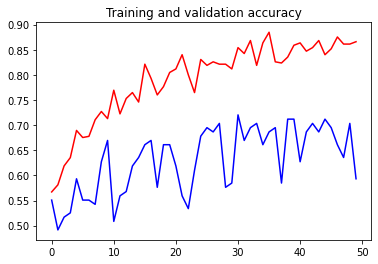

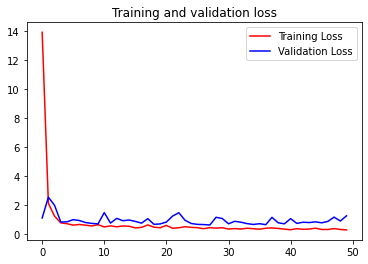

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred,axis=0)
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_true,y_pred))

TypeError: ignored

In [ ]:
print(roc_auc_score(y_true,y_pred))